#  9.7 序列到序列学习（seq2seq）
- **目录**
  - 9.7.1 seq2seq编码器
  - 9.7.2 seq2seq解码器
  - 9.7.3 seq2seq模型损失函数
  - 9.7.4 seq2seq模型训练
  - 9.7.5 seq2seq模型预测
  - 9.7.6 seq2seq模型预测序列的评估

正如我们在9.5节中看到的，
机器翻译中的输入序列和输出序列都是长度可变的。
为了解决这类问题，我们在9.6节
设计了一个通用的”编码器－解码器“架构。
本节，我们将使用两个循环神经网络的编码器和解码器，
并将其应用于**序列到序列（sequence to sequence，seq2seq）** 类的学习任务。

遵循编码器－解码器架构的设计原则，
循环神经网络编码器使用**长度可变的序列**作为输入，
将其转换为**固定形状的隐状态**。
换言之，**输入序列的信息被*编码*到循环神经网络编码器的隐状态中**。
为了连续生成输出序列的词元，
独立的循环神经网络解码器是基于输入序列的**编码信息**和输出序列**已经看见**的或者生成的词元来预测下一个词元。
图9.7.1演示了如何在机器翻译中使用两个循环神经网络进行序列到序列学习。

<center><img src='../img/seq2seq.svg' /></center>
<center>图9.7.1 使用循环神经网络编码器和循环神经网络解码器的序列到序列学习</center>

在图9.7.1中，
特定的“&lt;eos&gt;”表示序列结束词元。
一旦输出序列生成此词元，模型就会**停止预测。**
在循环神经网络解码器的初始化时间步，有两个特定的设计决定：
- 首先，特定的“&lt;bos&gt;”表示序列开始词元，它是解码器的输入序列的第一个词元。
- 其次，使用循环神经网络编码器**最终**的隐状态来初始化解码器的隐状态。

如图9.7.1所示，**编码器最终的隐状态在每一个时间步都作为解码器的输入序列的一部分**。
类似于图9.7.1中语言模型的训练，可以允许**标签成为原始的输出序列**，
从源序列词元“&lt;bos&gt;”, “Ils”, “regardent”, “.”到新序列词元“Ils”, “regardent”, “.”, “&lt;eos&gt;”来移动预测的位置。

- **要点：**
  - 序列到序列学习（seq2seq）是一种用于处理**长度可变**的输入和输出序列的学习任务。
  - 在机器翻译中，使用两个循环神经网络的编码器和解码器实现seq2seq学习。
  - 循环神经网络编码器将输入序列转换为**固定形状的隐状态**，将**输入序列的信息编码到隐状态中**。
  - 循环神经网络解码器使用编码器的隐状态和输出序列已见或生成的词元来预测下一个词元，连续生成输出序列的词元。
  - 特定的“&lt;eos&gt;”表示序列结束词元，在解码器的初始化时间步使用特定的“&lt;bos&gt;”表示序列开始词元，**并使用编码器最终的隐状态来初始化解码器的隐状态**。
  - seq2seq学习中，可以允许标签成为原始的输出序列，通过移动预测的位置，实现不同的设计。

---
- **说明：如何理解编码器最终的隐状态在每一个时间步都作为解码器的输入序列的一部分？**
- Seq2Seq模型中，编码器处理完整个输入序列后，会产生一个最终的隐状态（hidden state）。
  - 这个隐状态被认为是输入序列的一个**浓缩表示**，包含了**整个输入序列的信息**。
  - 在解码阶段，这个最终隐状态会被传递给解码器，并在解码的每一个时间步都被用作输入的一部分。
- **编码器最终的隐状态:**
  - **循环神经网络（RNN）的特性:** RNNs 能够处理序列数据，通过在每个时间步传递隐状态来捕捉序列中的信息。
  - **编码器的作用:** 编码器RNN的任务是读取输入序列（例如，一个句子），并将其转换为一个固定长度的向量，即最终的隐状态。这个向量试图捕捉输入序列的**全部信息**。
  - 最终隐状态的意义: 这个最终隐状态可以被看作是输入序列的<b>“意义”或“表示”</b> 。它包含了模型从输入序列中提取的所有重要信息。
  - **在每一个时间步都作为解码器的输入序列的一部分:**
    * **解码器的作用:** 解码器RNN的任务是基于编码器提供的最终隐状态，逐步生成输出序列（例如，翻译后的句子）。
    * **时间步:** 解码器在**每个时间步**生成输出序列的一个元素（例如，一个单词）。
    * **作为输入的一部分:** 在每个时间步，解码器不仅接收前一个时间步生成的输出作为输入，还会接收编码器最终的隐状态。这意味着，解码器在生成每个单词时，都可以“看到”**整个输入序列的信息**。

- **主要功能**
  * **传递信息:** 编码器的最终隐状态是连接编码器和解码器的**桥梁**。它将输入序列的信息传递给解码器，使得解码器能够生成与输入序列相关的输出。
  * **提供上下文:** 通过在每个时间步都提供编码器的最终隐状态，解码器可以持续地获得输入序列的上下文信息，这对于生成准确的输出序列至关重要。
- **具体实现方式:**
  - 在实际实现中，编码器的最终隐状态通常会通过以下方式被用作解码器输入的一部分：
    * **直接拼接:** 将最终隐状态与解码器当前时间步的输入（例如，前一个时间步的输出）拼接在一起，作为解码器RNN的输入。
    * **作为初始隐状态:** 将最终隐状态作为解码器RNN的初始隐状态。这样，解码器在开始生成输出序列时，就拥有了输入序列的信息。
    * **注意力机制:** 在更复杂的模型中，可以使用注意力机制来**动态地选择编码器隐状态的不同部分**，并将其作为解码器输入的一部分。
- “编码器最终的隐状态在**每一个时间步**都作为解码器的输入序列的一部分”意味着，编码器将输入序列的信息压缩到一个最终隐状态中，并在解码的每个时间步将这个隐状态提供给解码器，以帮助解码器生成准确的输出序列。这种机制确保了输入序列的信息在整个解码过程中都被充分利用。
---

- 下面，我们动手构建 图9.7.1的设计，并将基 9.5节中介绍的“英－法”数据集来训练这个机器翻译模型。 

In [59]:
%matplotlib inline
import collections
import math
import torch
from torch import nn
import torch.nn.functional  as F
from d2l import torch as d2l

## 9.7.1 seq2seq编码器

从技术上讲，编码器将长度可变的输入序列转换成
**形状固定的上下文变量$\mathbf{c}$，**
并且将输入序列的信息在该上下文变量中进行**编码**(注意c是**固定长度**的)。
如图9.7.1所示，可以使用循环神经网络来设计编码器。

考虑由一个序列组成的样本（批量大小是$1$）。
假设输入序列是$x_1, \ldots, x_T$，
其中$x_t$是输入文本序列中的第$t$个词元。
在时间步$t$，循环神经网络将词元$x_t$的输入特征向量
$\mathbf{x}_t$和$\mathbf{h} _{t-1}$（即上一时间步的隐状态）
转换为$\mathbf{h}_t$（即当前步的隐状态）。
使用一个函数$f$来描述循环神经网络的循环层所做的变换：

$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}) \tag{9.7.1} $$

总之，编码器通过选定的函数$q$，
将所有时间步的隐状态转换为上下文变量：

$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T) \tag{9.7.2}$$

比如，当选择$q(\mathbf{h}_1, \ldots, \mathbf{h}_T) = \mathbf{h}_T$时
（就像图9.7.1中一样），
<b>上下文变量仅仅是输入序列在最后时间步的隐状态$\mathbf{h}_T$</b>。
（也就是上下文向量c只保留编码器最后的输出隐状态$H_t$，因此
最后只取出$H_t$时刻的state[1]作为上下文变量$\mathbf{c}$。
）

到目前为止，我们使用的是一个**单向循环神经网络来设计编码器**，
其中隐状态只依赖于输入子序列，
这个子序列是由输入序列的**开始位置到隐状态所在的时间步的位置**
（包括隐状态所在的时间步）组成。
我们也可以使用双向循环神经网络构造编码器，
其中隐状态依赖于**两个输入子序列**，
两个子序列是由隐状态所在的时间步的位置**之前的序列**和**之后的序列**（包括隐状态所在的时间步），
因此**隐状态对整个序列的信息都进行了编码**。

现在，让我们实现循环神经网络编码器。
注意，我们使用了**嵌入层（embedding layer）**
来获得输入序列中每个词元的特征向量。
嵌入层的权重是一个**矩阵**，
其**行数等于输入词表的大小（`vocab_size`）**，
其**列数等于特征向量的维度（`embed_size`）**（也就是词表中的每个词是一个样本，每个样本的特征是特征向量）。
对于任意输入词元的索引$i$，
嵌入层获取权重矩阵的第$i$行（从$0$开始）以返回其**特征向量**。
另外，本文选择了一个**多层门控循环单元**来实现编码器。

- **要点：**
  -  编码器将长度可变的输入序列转换为形状固定的上下文变量$\mathbf{c}$，并将输入序列的信息在该上下文变量中进行编码。
  - 使用循环神经网络来设计编码器，每个时间步$t$将词元$x_t$的输入特征向量$\mathbf{x}_t$和上一时间步的隐状态$\mathbf{h}_{t-1}$转换为当前时间步的隐状态$\mathbf{h}_t$，通过函数$f(\mathbf{x}_t, \mathbf{h}_{t-1})$来描述循环层的变换。
  - 编码器通过函数$q(\mathbf{h}_1, \ldots, \mathbf{h}_T)$将所有时间步的隐状态转换为上下文变量$\mathbf{c}$。当选择$q(\mathbf{h}_1, \ldots, \mathbf{h}_T) = \mathbf{h}_T$时，上下文变量仅仅是输入序列在最后时间步的隐状态$\mathbf{h}_T$。
  
  - 可以使用双向循环神经网络构造编码器，其中隐状态依赖于输入序列的两个子序列，分别是隐状态所在的时间步**之前**的子序列和隐状态所在的时间步**之后**的子序列，从而对整个序列的信息进行编码。
  - 在实现循环神经网络编码器时，使用嵌入层来获得输入序列中每个词元的**特征向量**，嵌入层的权重矩阵的行数等于输入词表的大小，列数等于特征向量的维度。对于任意输入词元的索引$i$，嵌入层获取权重矩阵的第$i$行（从$0$开始）以返回其特征向量。编码器选择多层门控循环单元来实现。

-----------

- **说明：**
- **(1)为何上下文变量c是固定长度的？**
  - 矩阵$\mathbf{c}$是固定长度的是因为编码器的设计原则是将长度可变的输入序列**转换成形状固定**的上下文变量$\mathbf{C}$，并将输入序列的信息在该上下文变量中进行编码。
  - 在机器翻译任务中，输入序列可能是一个句子，而不同句子的长度可以是不同的，因此需要将这些长度可变的输入序列转换成一个**统一的上下文表示**，以便后续的解码器能够根据这个上下文变量生成输出序列。
  - 在编码器的设计中，通常选择一个特定的函数$q$来将所有时间步的隐状态$\mathbf{h}_1, \ldots, \mathbf{h}_T$转换为上下文变量$\mathbf{c}$。
  - 一个**常见的选择**是将上下文变量$\mathbf{c}$设为输入序列在**最后时间步的隐状态**$\mathbf{h}_T$，即$\mathbf{c} = \mathbf{h}_T$。这样，无论输入序列的长度是多少，编码器都会将其编码成一个固定长度的上下文变量$\mathbf{c}$。
  - 固定长度的上下文变量$\mathbf{c}$在序列到序列学习中非常重要，因为**解码器需要一个固定长度的向量来初始化其隐状态**，以便连续生成输出序列的词元。
  - **如果上下文变量$\mathbf{c}$的长度也是可变的，那么解码器的初始化将变得复杂，并且会引入更多的不稳定性和不可预测性，影响模型的训练和性能**。
  - 因此，通过将长度可变的输入序列编码成固定长度的上下文变量$\mathbf{c}$，编码器为解码器提供了一个**统一的、有限的信息表示**，使得解码器能够更好地对输入序列进行建模和生成输出序列。
  - 这种编码器-解码器架构在序列到序列学习任务中非常有效，并且已经被广泛应用于机器翻译、文本生成等自然语言处理任务中。

- **(2)公式9.7.2：$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T)$如何理解？**
  - 公式9.7.2表示编码器将长度可变的输入序列的所有时间步的隐状态$\mathbf{h}_1, \ldots, \mathbf{h}_T$通过一个函数$q$进行转换，得到一个形状固定的上下文变量$\mathbf{c}$。这个上下文变量$\mathbf{c}$用于将整个输入序列的信息进行编码，并且将这个编码后的信息**传递给解码器**，供其用于生成输出序列。
  - 具体来说，$\mathbf{h}_1, \ldots, \mathbf{h}_T$是编码器在不同时刻$t$的隐状态。在时间步$t$，编码器通过一个循环层的变换函数$f(\mathbf{x}_t, \mathbf{h}_{t-1})$，将输入词元的特征向量$\mathbf{x}_t$和上一时间步的隐状态$\mathbf{h}_{t-1}$转换为当前时间步的隐状态$\mathbf{h}_t$。这样，编码器在整个序列上运行，每个时间步都会产生一个隐状态$\mathbf{h}_t$。
  - 然后，函数$q$的作用是将所有时间步的隐状态$\mathbf{h}_1, \ldots, \mathbf{h}_T$转换成一个**形状固定**的上下文变量$\mathbf{c}$。这个函数$q$可以是任意的函数，用于将多个隐状态合并成一个固定长度的向量。例如，可以选择$q(\mathbf{h}_1, \ldots, \mathbf{h}_T) = \mathbf{h}_T$，即将上下文变量$\mathbf{c}$设置为输入序列在最后时间步的隐状态$\mathbf{h}_T$。这样，上下文变量$\mathbf{c}$就是**整个输入序列的编码信息**，其中包含了输入序列中每个时间步的隐状态的信息。
  - 在序列到序列学习中，编码器的目的是将输入序列的信息编码成一个固定长度的上下文变量，这个上下文变量作为解码器的初始隐状态，帮助解码器连续生成输出序列的词元。因此，通过函数$q$将多个隐状态合并成一个固定长度的上下文变量是十分关键的，它为解码器提供了一个**统一的、有限的**信息表示，使得解码器能够更好地对输入序列进行建模和生成输出序列。
  - 公式(9.7.2)中的编码器函数$q$用于将所有时间步的隐状态$\mathbf{h}_1, \ldots, \mathbf{h}_T$转换成一个形状固定的上下文变量$\mathbf{c}$，这个上下文变量$\mathbf{c}$用于将输入序列的信息编码成一个固定长度的向量，供解码器使用。具体来说，编码器的设计目的是将长度可变的输入序列编码成一个固定长度的上下文向量，以便后续解码器能够根据这个上下文向量生成输出序列。
  - 在更复杂的模型中，如使用**注意力机制**的模型，函数𝑞可能是一个加权平均，比如$q(\mathbf{h}_1, \ldots, \mathbf{h}_T)= 𝑤_1𝐡_1+…+𝑤_𝑇𝐡_𝑇$，其中$𝑤_1,…,𝑤_𝑇$是权重，可以通过训练数据学习得到。在这样的模型中，上下文向量𝐜是所有隐藏状态的加权平均，它不仅包含了最后一个时间步的信息，而且还包含了其他所有时间步的信息。

- **(3)嵌入层的主要作用与功能是什么？**
  - 嵌入层（Embedding Layer）是深度学习中常用的一种技术，其主要功能作用是将**离散型的输入**（如词元或类别）转换成**连续型的特征向量**。
    - 在自然语言处理任务中，嵌入层通常用于将文本中的词元映射成实数向量，也称为**词嵌入（Word Embeddings）**。
    - 嵌入层在文本处理、自然语言处理以及图像处理等领域都有广泛的应用。
  - 嵌入层的主要作用有以下几个方面：
    - **降维：** 嵌入层可以将**高维的离散输入**（如词表的大小）映射到**低维的连续空间**中。这样做的好处是，可以将原本**稀疏的高维特征表示**转换为**稠密的低维特征表示**，从而减少模型参数量，降低计算复杂度，并且提高模型的泛化能力。
    - **语义表示：** 嵌入层通过学习将相似的词元映射到相近的特征向量，从而在嵌入空间中保持**语义的相似性**。这意味着，语义上相似的词元在**嵌入空间中的距离应该较近**，从而方便模型捕捉词元之间的语义关系。例如，"king" 和 "queen" 在嵌入空间中应该更接近，因为它们是同一语义类别的词元。
    - **特征学习：** 嵌入层可以学习词元的分布式表示，使得每个维度对应于词元的某个特定特征。这样，模型可以根据需要灵活地选择和组合不同维度的特征来表达**不同的语义和上下文信息**，从而提高模型的表达能力和泛化能力。
    - **稠密表示：** 嵌入层生成的特征向量是**连续的、稠密的**，而不是原始的离散表示。这种连续稠密表示有利于深度学习模型进行优化和训练，并且可以更好地捕捉数据中的**细微变化和模式**。
    - **词元编码：** 嵌入层可以将不同的词元**编码成向量**，使得模型能够处理词元级别的输入，而不是直接处理词元的标识符。这样做可以更方便地在模型中进行处理和操作，同时**减少模型的复杂性和计算开销**。



--------

In [60]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        '''
        Embedding参数列表：
        Num_embeddings (int) -嵌入字典（或词表）的大小，本例为10
        Embedding_dim (int)  -每个嵌入向量的大小，本例为8
        该类的详细说明见后。
        '''
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        '''
        通过GRU实现嵌入层。
        （1）嵌入层维度，就是特征维度（一般8的倍数,在本例中是8）。
        （2）隐状态单元数(本例中是16),循环层层数（本例是2）,dropout消除率（本例中缺省为0）。
        例子传入4个参数的值为：8,16,2,0，此处的特征维数类似前面几节的独热编码。
        二者其实区别不是很大。说到底，嵌入层就是一个表征方式而已。
        '''
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        '''
        嵌入层输出'X'的形状：(batch_size,num_steps,embed_size)        
        本例中为(4,7),经过嵌入层之后X转换成(4,7,8)
        '''
        X = self.embedding(X)
        
        '''
        在循环神经网络模型中，第1维对应于时间步数，
        第2维是批量大小，第3维是嵌入向量大小
        将维度从(4,7,8)变换成(7,4,8)。
        '''
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        '''
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        '''
        output, state = self.rnn(X)        
        return output, state

- 由于这里使用的是门控循环单元，所以在最后一个时间步的多层隐状态的形状是（隐藏层的数量，批量大小，隐藏单元的数量）。
- 如果使用长短期记忆网络，`state`中还将包含记忆单元信息。

-----------

- **说明：nn.Embedding类说明**
  - nn.Embedding类：一个简单的查找表，存储固定字典的嵌入和大小。此模块通常用于存储词嵌入，并使用索引检索它们。模块的输入是一个索引列表，输出是相应的词嵌入。
  - nn.Embedding的主要功能另一种解释是：为每个输入词元索引（整数）获取对应的嵌入向量。它将输入的整数索引映射到词嵌入矩阵中的**对应行**，并返回这些嵌入向量作为模型的输入。词嵌入矩阵是nn.Embedding类的一个参数，其**行数等于词汇表的大小**，**列数等于特征向量的维度**。
  - 嵌入这个概念不是很好理解，说到底就是一个**向量**，用来表征某个语言模型里tokens的**特征**或图像的像素特征。词嵌入是自然语言处理（NLP）中语言模型与表征学习技术的统称。概念上而言，它是指**把一个维数为所有词的数量的高维空间嵌入到一个维数低得多的连续向量空间中，每个单词或词组被映射为实数域上的向量**。        
  - 所谓词嵌入，通俗来讲，是指**将一个单词(word)转换为一个向量 (vector)表示**，所以词嵌入有时又被叫作“word2vec"。 
  - 所谓 word2vec，是指学习一个映射f，它可以将单词变成向量表示: vec = f(word)。在 RNN 的每一步输入中，不再用词语的独热表示，而是用映射之后的 vec输入模型，这样模型不仅会得到更丰富的有关词语的信息，而且**输入的维数还下降**了，因此性能会大大提高。嵌入层的权重是一个矩阵：(词表大小,特征维度)。
  - 在此使用了torch的Embedding模型，本例中词嵌入维度是(10,8)
 


---------

- 循环层返回变量的说明可以参考8.6节。
- 下面，我们实例化**上述编码器的实现**：
  - 使用一个两层门控循环单元编码器，其隐藏单元数为$16$。
  - 给定一小批量的输入序列`X`（批量大小为$4$，时间步为$7$）。
  - 在完成所有时间步后，最后一层的隐状态的输出是一个张量（`output`由编码器的循环层返回）：
    - 其形状为（时间步数，批量大小，隐藏单元数）。


In [61]:
## num_hiddens原值为16
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
'''
eval函数将模块设置为评估模式。
这只对某些模块有影响。
如受影响，具体模块在训练/评估模式下的行为详见相关模块文档。
'''
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)

'''
(1)output:输出层的形状为(时间步数,批量大小,隐状态单元数).
   注意这个输出并非Y，而是所有时间步的最后一层的隐状态。可参考9.1节的解析。
(2)state（隐状态）层的形状为(层数,批量大小,隐状态单元数)
  落脚点仍是在隐状态。
'''
output.shape,state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

-------------
- **说明：output与state保存数据**
  - output：这个变量保存了GRU在**所有时间步的隐状态**。其形状通常为 (序列长度或时间步数, 批量大小, 隐藏层大小)。这就意味着，对于输入序列中的每一个时间步，output都保存了经过GRU处理后的隐藏状态。
  - state：这个变量保存了GRU的**最后一个时间步的隐状态**。对于GRU，这实际上与output的最后一个时间步是相同的，即 state 等价于 output[-1]。state 的形状通常为 (层数, 批量大小, 隐藏层大小)。
  - 具体来说，output 保存了序列中**每个词元**的信息，这些信息可能会被解码器在生成每个元素时使用。而 state 保存了整个输入序列的上下文信息，这在一些seq2seq模型中，如基本的循环神经网络（RNN）中，被**作为解码器的初始隐状态**。
  - 在实际的模型如注意力机制中，解码器可能会**更多地依赖 output** 而非 state 来获取输入序列的信息。
  - 具体可参见GRU的官方文档：https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
<img src='..\img\9_7_3.png' width=600px/> 


In [62]:
'''
输出状态Ht,只取出最上面一层的输出状态，就是用state[1]，也是所谓上下文变量c。
后面的解码器要使用到编码器最后的输出状态也是该变量。
output保存的序列中7个tokens的批量隐状态，即7个tokens的state[1]，
而state[0]没保存在ouput中。
'''
state[1],state[0],output[6]

(tensor([[ 0.3092,  0.0095, -0.2642, -0.1144, -0.1634,  0.3695,  0.1200,  0.1150,
          -0.0195, -0.0350,  0.2581, -0.0958,  0.0317,  0.1078,  0.2420, -0.4597],
         [ 0.3092,  0.0095, -0.2642, -0.1144, -0.1634,  0.3695,  0.1200,  0.1150,
          -0.0195, -0.0350,  0.2581, -0.0958,  0.0317,  0.1078,  0.2420, -0.4597],
         [ 0.3092,  0.0095, -0.2642, -0.1144, -0.1634,  0.3695,  0.1200,  0.1150,
          -0.0195, -0.0350,  0.2581, -0.0958,  0.0317,  0.1078,  0.2420, -0.4597],
         [ 0.3092,  0.0095, -0.2642, -0.1144, -0.1634,  0.3695,  0.1200,  0.1150,
          -0.0195, -0.0350,  0.2581, -0.0958,  0.0317,  0.1078,  0.2420, -0.4597]],
        grad_fn=<SelectBackward0>),
 tensor([[-0.2566, -0.0290, -0.0556,  0.3312, -0.5949,  0.3050,  0.2708,  0.0247,
           0.0411,  0.3010, -0.1174, -0.3026, -0.7427,  0.1963, -0.1534, -0.4181],
         [-0.2566, -0.0290, -0.0556,  0.3312, -0.5949,  0.3050,  0.2708,  0.0247,
           0.0411,  0.3010, -0.1174, -0.3026, -0.7427,  

In [63]:
'''
上下文变量c的每一行其实相等。
在RNN和GRU中 state[-1] 和 output[-1] 是相同的，
但在其他类型的网络中可能并非如此，比如LSTM就不同。
'''
state[-1][0]==state[-1][1], state[-1] == output[-1]

(tensor([True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True]),
 tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True]]))

-------------

## 9.7.2 seq2seq解码器
正如上文提到的，编码器输出的上下文变量$\mathbf{c}$
对整个输入序列$x_1, \ldots, x_T$进行编码。
来自训练数据集的输出序列$y_1, y_2, \ldots, y_{T'}$，
对于每个时间步$t'$（与输入序列或编码器的时间步$t$不同），
<b>解码器输出$y_{t'}$的概率取决于先前的输出子序列
$y_1, \ldots, y_{t'-1}$和上下文变量$\mathbf{c}$，
即$P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$。</b>

为了在序列上模型化这种条件概率，
我们可以使用另一个循环神经网络作为解码器。
<b>在输出序列上的任意时间步$t^\prime$，
循环神经网络将来自上一时间步的输出$y_{t^\prime-1}$
和上下文变量$\mathbf{c}$作为其输入，
然后在当前时间步将它们和上一隐状态
$\mathbf{s}_{t^\prime-1}$转换为隐状态$\mathbf{s}_{t^\prime}$</b>。
因此，可以使用函数$g$来表示解码器的隐藏层的变换（需要使用到3个变量）：

$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}) \tag{9.7.3}$$

在获得解码器的隐状态之后，
我们可以使用输出层和**softmax操作**来计算在时间步$t^\prime$时输出$y_{t^\prime}$的**条件概率分布**
$P(y_{t^\prime} \mid y_1, \ldots, y_{t^\prime-1}, \mathbf{c})$。

根据图9.7.1，当实现解码器时，
我们**直接使用编码器最后一个时间步的隐状态来初始化解码器的隐状态**。
这就要求使用循环神经网络实现的编码器和解码器具有**相同数量的层和隐藏单元**。
为了进一步包含经过编码的输入序列的信息，
**上下文变量在所有的时间步与解码器的输入进行拼接（concatenate）**。
为了预测输出词元的概率分布，
在循环神经网络解码器的最后一层使用全连接层来变换隐状态。

- **要点：**
  -  **解码器的目标**：在序列到序列模型中，解码器的目标是给定上下文变量 $c$，它对整个输入序列进行编码，生成对应的输出序列。
  - **条件概率的模型化**：对于输出序列中的每一个时间步 $t'$，解码器输出 $y_{t'}$ 的概率取决于**先前的输出子序列** $y_1,…,y_{t'-1}$ 和上下文变量 $c$，即 $P(y_{t'}|y_1,…,y_{t'-1},c)$。这个条件概率是通过另一个循环神经网络（RNN）作为解码器来建模的。
  - **解码器的输入**：在输出序列上的任意时间步 $t'$，RNN 将来自上一时间步的输出 $y_{t'-1}$ 和上下文变量 $c$ 作为其输入。
  - **隐藏状态的变换**：RNN 在当前时间步将 $y_{t'-1}$、$c$ 和上一隐状态 $s_{t'-1}$ 转换为隐状态 $s_{t'}$，即 $s_{t'} = g(y_{t'-1}, c, s_{t'-1})$。
  -  **输出的条件概率分布**：得到解码器的隐藏状态后，我们可以使用全连接层和 softmax 操作来计算在时间步 $t'$ 时输出 $y_{t'}$ 的条件概率分布 $P(y_{t'}|y_1,…,y_{t'-1},c)$。
  - **初始化解码器的隐藏状态**：编码器在最后一个时间步的隐藏状态用来初始化解码器的隐藏状态。
  - **拼接上下文变量和解码器的输入**：为了进一步包含经过编码的输入序列的信息，上下文变量在所有的时间步与解码器的输入进行拼接（concatenate）。

In [64]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        '''
        d2l.Decoder和d2l.Encoder都是接口类型，里面的函数没实现，
        类似C++中的纯虚拟函数和Java中的interface。
        注意在实现接口时，需要在子类中的初始化函数中通过super调用父类的初始化函数。
        '''
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        '''
        vocab_size, embed_size分别是词表大小和嵌入大小。
        '''
        self.embedding = nn.Embedding(vocab_size, embed_size)
        '''
        第一个输入大小：8+16=24，此处将嵌入层单元数与隐状态单元数相加是为了将隐状态和输入的维度拼接操作。
        参数值依次为：24,16,2,0.
        因此此处是就是“拼接上下文变量和解码器的输入”。
        因为输入的嵌入层处理的数据(7,4,8)，将输入的最后一维8与上下文变量c的最后一维拼接，
        也就是将8+16=24。
        公式9.7.3
        
        '''
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        ## 参数值依次为：16,10
        self.dense = nn.Linear(num_hiddens, vocab_size)

    
    def init_state(self, enc_outputs, *args):
        '''
        GRU前向传播返回两个值：一个是最后一层的所有时间步，所有批量的隐状态；
        第二个是最后一个时间步的所有层的所有批量的隐状态。
        两个值放在一个tuple里。
        此处enc_outputs[1]是取出第二个值，即最后一个时间步的隐状态，
        即output, state中的state
        '''
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        '''
        尤其要注意：解码器的输入X是强制教学Teacher Forcing，后面有介绍。
        初始X形状(4,7), embedding之后变成(4,7,8), permute之后变成(7,4,8)。
        4是批量大小；7是序列长度(时间步数)；8是嵌入层大小
        '''        
        X = self.embedding(X).permute(1, 0, 2)
        
        # 广播context，使其具有与X相同的num_steps
        '''
        state形状是(2, 4, 16),state[-1]的形状是(1, 4, 16)
        将第一维复制(即X.shape[0]，X第一维的形状)，后两维不复制。
        那么结果就是(7, 4, 16)
        '''
        context = state[-1].repeat(X.shape[0], 1, 1)
        
        '''
        上文中讲的：
        为了进一步包含经过编码的输入序列的信息（经过模型左边的编码器进行了编码）， 
        上下文变量在所有的时间步与解码器的输入(强制教学)进行拼接（concatenate）.
        实际上就是在第3个维度，将多个矩阵的列在横向进行拼接。
        那么X_and_context形状变成：(7,4,24)
        '''
        X_and_context = torch.cat((X, context), 2)
        
        
        '''
        前面定义的GRU(24, 16, 2, 0), 
        输入X_and_context的形状为：(7,4,24),
        state形状为：(2, 4, 16)，注意是2层GRU。
        
        输出的output是(7, 4, 16)，
        输出state形状保持不变。
        '''
        output, state = self.rnn(X_and_context, state)
        
        '''
        GRU的输出要经过全连接稠密层的前馈网络，获取概率列表，即每个时间步的预测输出。
        前面定义的Linear(16, 10),
        此时output输出为(7, 4, 16)@(16, 10)，输出结果为(7, 4, 10),
        最后经过permute之后，形状为(4, 7, 10)
        '''
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

----------------------
- **说明：多维张量的复制,repeat函数用法**

In [65]:
## 多维张量的复制
r=torch.arange(1,25,1).reshape((2,3,4))
r1=torch.arange(26,50,1).reshape((2,3,4))
## repeat参数是指对应维度复制的次数，本例中第一维复制4次，后两维不复制。
## r的维度是(2,3,4)，r[-1]的维度是(1,3,4),repeat之后是(4,3,4)
r[-1].repeat(4,1,1), r[-1].repeat(4,1,1).shape

(tensor([[[13, 14, 15, 16],
          [17, 18, 19, 20],
          [21, 22, 23, 24]],
 
         [[13, 14, 15, 16],
          [17, 18, 19, 20],
          [21, 22, 23, 24]],
 
         [[13, 14, 15, 16],
          [17, 18, 19, 20],
          [21, 22, 23, 24]],
 
         [[13, 14, 15, 16],
          [17, 18, 19, 20],
          [21, 22, 23, 24]]]),
 torch.Size([4, 3, 4]))

In [66]:
r[-1].repeat(4,3,2),r[-1].repeat(4,3,2).shape

(tensor([[[13, 14, 15, 16, 13, 14, 15, 16],
          [17, 18, 19, 20, 17, 18, 19, 20],
          [21, 22, 23, 24, 21, 22, 23, 24],
          [13, 14, 15, 16, 13, 14, 15, 16],
          [17, 18, 19, 20, 17, 18, 19, 20],
          [21, 22, 23, 24, 21, 22, 23, 24],
          [13, 14, 15, 16, 13, 14, 15, 16],
          [17, 18, 19, 20, 17, 18, 19, 20],
          [21, 22, 23, 24, 21, 22, 23, 24]],
 
         [[13, 14, 15, 16, 13, 14, 15, 16],
          [17, 18, 19, 20, 17, 18, 19, 20],
          [21, 22, 23, 24, 21, 22, 23, 24],
          [13, 14, 15, 16, 13, 14, 15, 16],
          [17, 18, 19, 20, 17, 18, 19, 20],
          [21, 22, 23, 24, 21, 22, 23, 24],
          [13, 14, 15, 16, 13, 14, 15, 16],
          [17, 18, 19, 20, 17, 18, 19, 20],
          [21, 22, 23, 24, 21, 22, 23, 24]],
 
         [[13, 14, 15, 16, 13, 14, 15, 16],
          [17, 18, 19, 20, 17, 18, 19, 20],
          [21, 22, 23, 24, 21, 22, 23, 24],
          [13, 14, 15, 16, 13, 14, 15, 16],
          [17, 18, 19, 20,

In [67]:
## 当dim=2时，将矩阵里的列进行横向拼接
torch.cat((r,r1),2)

tensor([[[ 1,  2,  3,  4, 26, 27, 28, 29],
         [ 5,  6,  7,  8, 30, 31, 32, 33],
         [ 9, 10, 11, 12, 34, 35, 36, 37]],

        [[13, 14, 15, 16, 38, 39, 40, 41],
         [17, 18, 19, 20, 42, 43, 44, 45],
         [21, 22, 23, 24, 46, 47, 48, 49]]])

------------------------

- 下面，我们用与前面提到的编码器中相同的超参数来**实例化解码器**。
- 如我们所见，解码器的输出形状变为（批量大小，时间步数，词表大小），
  - 其中张量的最后一个维度存储预测的词元分布。


In [68]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
init_state = decoder.init_state(encoder(X))
print('init_state.shape: ',init_state.shape)
output, state = decoder(X, init_state)

'''
output的(4,7,10)，分别为：(批量大小，时间步数，词表大小)
'''
print('\n最终输出output和state的值分别是：')
output.shape, state.shape

init_state.shape:  torch.Size([2, 4, 16])

最终输出output和state的值分别是：


(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

- 总之，上述循环神经网络“编码器－解码器”模型中的各层如图9.7.2所示。

<center><img src='../img/seq2seq-details.svg'/></center>
<center>图9.7.2 循环神经网络编码器-解码器模型中的层</center>

## 9.7.3 seq2seq模型损失函数

- 在每个时间步，解码器预测了输出词元的概率分布。
类似于语言模型，可以**使用softmax来获得分布，
并通过计算交叉熵损失函数来进行优化**。
- 回想一下9.5节中，特定的填充词元被添加到序列的末尾，
因此不同长度的序列可以以相同形状的小批量加载。
但是，我们应该**将填充词元的预测排除在损失函数的计算之外**（使用mask掩码机制来实现）。

- 为此，我们可以使用下面的`sequence_mask`函数
**通过零值化屏蔽不相关的项**，
以便后面任何不相关预测的计算都是与零的乘积，结果都等于零。
- 例如，如果两个序列的有效长度（不包括填充词元）分别为$1$和$2$，
则第一个序列的第一项和第二个序列的前两项之后的剩余项将被**清除为零**。

In [69]:
#@save
## 序列屏蔽的目的在于将固定长度序列中的填充项零值化后以便不计算其权重
## 此时文本序列的有效长度valid_len起作用了
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    ## size函数的参数表示获取某个维的大小
    ## 此处获取第二维的大小，然后在该维度上进行序列屏蔽
    maxlen = X.size(1)
    '''
    小于号前面的张量纵向广播，后面张量横向广播，然后再进行比较。
    注意None所谓索引时可以扩充张量的维度。
    在本示例中：maxlen=3, 小于号左边部分是[[0,1,2]]，形状是(1, 3); 小于号右边部分是[[1],[2]]，形状为(2,1)
    然后开始广播，左边是：[[0,1,2],[0,1,2]],右边是[[1,1,1],[2,2,2]];二者的形状皆变成(2, 3)
    再按元素进行比较，mask是[[True, False, False],[True, True, False]]
    '''
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    '''
    ~mask=[[False, True, True],[False, False, True]]
    下述表达式就是~mask为True的地方元素的值为value，即0。
    其主要用意是将X每一行索引在val_len后面的元素设为0。
    '''
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

------------
- **说明：通过None扩展维度**
  - 在下例中，使用索引操作`None` 为 `t` 和 `v` 添加一个额外的维度。
    - `None` 索引等同于 np.newaxis，用于增加一个维度。
  - `t[None,:]` 在 `t` 的第一维上添加一个维度，`v[:,None]` 在 `v` 的第二维上添加一个维度。
  - 使用 `None` 来增加一个维度，变换得到的 `t` 和 `v` 形状如下：
    - `t[None,:]` 的形状为 `(1, 3)`，表示为 `[[0, 1, 2]]`；
    - `v[:,None]` 的形状为 `(2, 1)`，表示为 `[[1], [2]]`。
  - 这一步的结果是两个形状为 `(1, 3)` 和 `(2, 1)` 的二维张量。
  - 利用 PyTorch 的广播机制，将形状为 `(1, 3)` 和 `(2, 1)` 的两个张量进行比较。
  - 根据广播机制，如果两个张量的尺寸不兼容，那么张量的形状会沿着长度为1的维度进行扩展，以匹配另一个张量的形状。
  - 在这里，`t[None,:]`的形状会扩展为`(2, 3)`，`v[:,None]`的形状会扩展为 `(2, 3)`。
  - 具体来说：
    - `t[None,:]` 在第0维（行）上复制，扩展为 `(2, 3)`，表示为 `[[0, 1, 2], [0, 1, 2]]`；
    - `v[:,None]` 在第1维（列）上复制，扩展为 `(2, 3)`，表示为 `[[1, 1, 1], [2, 2, 2]]`。
  - 然后在比较操作中，PyTorch的广播机制会将两者扩展为相同的形状。
  - 这样就得到了一个形状为 `(2, 3)` 的布尔张量，表示 `t` 中的每个元素是否小于 `v` 中的元素。

In [70]:
t = torch.tensor([0,1,2])
v = torch.tensor([1, 2])
t[None,:], v[:,None], t[None,:] < v[:,None], ~(t[None,:] < v[:,None])

(tensor([[0, 1, 2]]),
 tensor([[1],
         [2]]),
 tensor([[ True, False, False],
         [ True,  True, False]]),
 tensor([[False,  True,  True],
         [False, False,  True]]))

In [71]:
## [None,:]增加第一维; [:,None]，增加第二维。
m=torch.arange(6,dtype=torch.float32)
m.shape,m[None,:],m[:,None],m[None,:].shape,m[:,None].shape

(torch.Size([6]),
 tensor([[0., 1., 2., 3., 4., 5.]]),
 tensor([[0.],
         [1.],
         [2.],
         [3.],
         [4.],
         [5.]]),
 torch.Size([1, 6]),
 torch.Size([6, 1]))

In [72]:
## 前者纵向广播，后者横向广播，直到二者形状相同，然后再按元素进行比较
m[None,:]<m[:,None]

tensor([[False, False, False, False, False, False],
        [ True, False, False, False, False, False],
        [ True,  True, False, False, False, False],
        [ True,  True,  True, False, False, False],
        [ True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True, False]])

In [73]:
t.shape

torch.Size([3])

-----------------

- 我们还可以使用此函数屏蔽最后几个轴上的所有项。
- 如果愿意，也可以使用指定的非零值来替换这些项。


In [74]:
'''
maxlen = X.size(1)
mask = torch.arange((maxlen), dtype=torch.float32,
                    device=X.device)[None, :] < valid_len[:, None]
（1）maxlen=3
（2）mask=[[0,1,2]]<[[1],[2]]
（3）mask的值是[[True, False, False],[True, True, False]]
（4） ~mask=[[False, True, True],[False, False, True]]
（5）转换索引就是：[0,1],[0,2],[1,2]被修改成-1，也就是被屏蔽的对象。
（6）通俗讲，就是张量是包含2个3行4列的矩阵，此功能更就是在2个矩阵的行上进行屏蔽。
     即第1个矩阵的第2,3两行被屏蔽，第2个矩阵的第3行被屏蔽。
（7）首先是sequence_mask函数中的maxlen=X.size(1)，
     其次[None, :]和[:, None]的用法表示是在X的第2维上进行屏蔽：
     如果X是2维张量，那么就是在张量的列上进行屏蔽操作；
     如果X是3维张量，那么就是在矩阵的行上进行操作，都是张量的第2维。
'''
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

- 我们可以**通过扩展softmax交叉熵损失函数来遮蔽不相关的预测**。
  - 最初，所有预测词元的掩码都设置为1。
  - 一旦给定了有效长度，与**填充词元**对应的掩码将被设置为0。
  - 最后，将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。


In [17]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        ## 应该是将固定长度序列的填充部分给屏蔽
        ## 当然不是直接屏蔽，而是通过与权重0相乘，将其设为零
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        
        ## permute(0, 2, 1)将张量中的矩阵分别转置
        ## pred重排之后的形状是(batch_size,vocab_size,num_steps)
        ## label形状是(batch_size,num_steps)
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        ## unweighted_loss * weights是将屏蔽的部分权重损失设置为0
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

-------

- **说明：CrossEntropyLoss的参数顺序以及为何代码中为何调用pred.permute(0, 2, 1)**
  - 在本例中，词表的大小即表示类型的多少。参数的d1,...dk在此处是指序列长度（时间步数）。
  - 因而在计算交叉熵时，输入input张量的形状应该是(批量大小，词表(类型)大小，序列长度)
  - `pred.permute(0, 2, 1)` 是用来改变 `pred` 的张量的维度顺序的。`permute` 函数接收一系列维度索引，返回按这些索引重排的新张量。
  - 在 PyTorch 中，交叉熵损失函数 `nn.CrossEntropyLoss()` 要求输入 `pred` 的形状是 `(N, C, ...)`，其中 `N` 是批次大小，`C` 是类别数量，后面的 `...` 代表任意数量的额外维度。而本例中 `pred` 的原始形状是 `(batch_size, num_steps, vocab_size)`，即 `(N, ..., C)`。
  - 这是与交叉熵损失函数的要求不符的。因此，本例使用 `permute(0, 2, 1)` 来交换第二个和第三个维度，使得 `pred` 的形状变为 `(batch_size, vocab_size, num_steps)`，即 `(N, C, ...)`，这样就符合交叉熵损失函数的要求了。
  - CrossEntropyLoss的输入输出形状：
<img src='../img/9_7_1.png' width=600 height=600>

In [76]:
## 交叉熵损失计算
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(4, 7, 10, requires_grad=True)
target = torch.empty(4, 7, dtype=torch.long).random_(5)# 类似tensor([2, 2, 0])
loss.reduction = 'none'
output = loss(input.permute(0,2,1), target)
# 此调用方式效果一样
# output = loss.forward(input.permute(0,2,1), target)
# 损失
output

tensor([[2.7949, 2.4466, 2.7947, 0.7909, 3.1993, 3.2717, 2.9942],
        [2.9812, 4.2825, 1.4594, 2.9519, 3.1399, 2.3589, 2.9363],
        [2.8042, 1.8205, 2.4484, 2.6666, 5.1029, 3.6224, 2.6319],
        [1.2541, 2.7896, 1.9238, 3.5010, 3.0225, 2.6173, 3.6890]],
       grad_fn=<ViewBackward0>)

In [77]:
'''
全手工实现：
（1）计算对象是张量中所包含矩阵的列，也就是第3维
（2）前面代码中的pred.permute(0, 2, 1),将预测结果的维度进行重排。
     即将作为预测结果的vocab_size从第3维重排到第2维，也就是将行重排成列。
     从(4, 7, 10)重排成(4，10, 7)，也就是每个小批量的7个tockens的vocab索引独热编码
     在矩阵中是以列的形式存在的。
（3）因此在交叉熵损失也是计算利用tokens的预测独热编码与词表实际索引标签进行对比来计算的。
'''
output2 = torch.zeros(4,7)
input2 = input.permute(0, 2, 1)
## 最外层循环是张量的矩阵个数，此处为2
for i in torch.arange(input2.shape[0]):
    ## 里层迭代是每个矩阵的列，注意是shape[1]表示矩阵的列数，此处为4
    for j in torch.arange(input2[i].shape[1]):
        '''
        交叉熵计算：-X[label]+log(sum(exp(X[j])))
        (1) X[label]表示标签索引对应该列第label个元素，
            此处为input[i,:,j][target[i,j]]，
            input[i,:,j]为X，
            target[i,j]为该列的标签；
        (2) exp(X[j])对该列各数据求e的X[j]次方；
        (3) 然后对上述各值求和；
        (4) 对和求自然对数。
        (5) 再将X[label]与对数相加，即得出该列的交叉熵。
        '''
        output2[i,j] = -input2[i,:,j][target[i,j]]+torch.log(torch.sum(torch.exp(input2[i,:,j])))        
        
output2

tensor([[2.7949, 2.4466, 2.7947, 0.7909, 3.1993, 3.2717, 2.9942],
        [2.9812, 4.2825, 1.4594, 2.9519, 3.1399, 2.3589, 2.9363],
        [2.8042, 1.8205, 2.4484, 2.6666, 5.1029, 3.6224, 2.6319],
        [1.2541, 2.7896, 1.9238, 3.5010, 3.0225, 2.6173, 3.6890]],
       grad_fn=<CopySlices>)

In [78]:
# 平均损失：手工计算与调用torch的cross_entropy计算，结果一致
torch.sum(output2)/(input2.shape[0]*input2.shape[2]),F.cross_entropy(input2, target)

(tensor(2.7963, grad_fn=<DivBackward0>),
 tensor(2.7963, grad_fn=<NllLoss2DBackward0>))

In [79]:
input.shape, input2.shape

(torch.Size([4, 7, 10]), torch.Size([4, 10, 7]))

In [80]:
# 掩码交叉熵损失，或掩码softmax损失的手工实现过程
valid_len=torch.tensor([3,4,2,1])
celoss = MaskedSoftmaxCELoss()
celoss(input, target, valid_len)

tensor([1.1480, 1.6679, 0.6607, 0.1792], grad_fn=<MeanBackward1>)

In [81]:
# 计算掩码权重矩阵
X = torch.ones(4,7)
weights = sequence_mask(X, valid_len)
weights

tensor([[1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])

In [82]:
# 计算掩码损失，然后计算批量中每个序列的平均损失（即按照每个序列词元的损失进行平均）
(output*weights), (output*weights).mean(dim=1)

(tensor([[2.7949, 2.4466, 2.7947, 0.0000, 0.0000, 0.0000, 0.0000],
         [2.9812, 4.2825, 1.4594, 2.9519, 0.0000, 0.0000, 0.0000],
         [2.8042, 1.8205, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.2541, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
        grad_fn=<MulBackward0>),
 tensor([1.1480, 1.6679, 0.6607, 0.1792], grad_fn=<MeanBackward1>))

--------------

- 可以创建三个相同的序列来进行**代码健全性检查**，
- 然后分别指定这些序列的有效长度为$4$、$2$和$0$。
- 结果就是，第一个序列的损失应为第二个序列的两倍，而第三个序列的损失应为零。


In [83]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

## 9.7.4 seq2seq模型训练


- 在下面的循环训练过程中，如图9.7.1所示，
特定的序列开始词元（“&lt;bos&gt;”）和**原始的输出序列（不包括序列结束词元“&lt;eos&gt;”）拼接在一起作为解码器的输入**。
- 这被称为**强制教学（teacher forcing）**，因为原始的输出序列（词元的标签）被送入解码器。
- 或者，将来自上一个时间步的**预测**得到的词元作为解码器的当前输入。
<center><img src='../img/seq2seq.svg' /></center>

In [84]:
#@save

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        '''
        两种模型的参数初始化方式还不一样
        （1）xavier_uniform_等初始化函数的参数都是Tensor类型。
        （2）Linear的权重参数保存在weight里，weight是一个Parameter类型，而Parameter是Tensor
             的子类，因此也是Tensor类型，可以作为初始化函数的参数。偏置保存在bias里，此处只初始化了
             Linear的权重参数。
        （3）GRU有多个参数，比如更新门、重置门、隐状态的隐藏层参数。每类参数作为一个Parameter对象保存在
             list里，因此需要迭代逐个取出作为初始化函数的参数，进行初始化。
             同样也只初始化权重参数。此处方法用到字典通过参数名取出参数张量进行初始化。
        
        '''
        if type(m) == nn.Linear:
            ## 只初始化权重，偏置不在此处初始化。
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            ## 取出参数名，然后通过参数名迭代进行初始化
            for param in m._flat_weights_names:
                ## 只初始化权重，偏置不在此处初始化
                ## 通过判断参数名字符串里是否包含'weight'来判断该参数是否为权重
                ## 然后在_parameters里通过参数名取出参数
                ## _parameters是一个OrderedDict类型参数，键名有序排列，即按照声明顺序排列。
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    ## 将初始化函数应用到模型
    net.apply(xavier_init_weights)
    net.to(device)
    ## 优化器的第一个参数是模型的待初始化参数，是一个生成器。
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    ## 模型进入训练模式
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            '''
            X: 源语言张量，形状: (64,10)，保存固定长度的、由词元序列构成的语句，
               长度为10，序列长度不足10，则填充到长度10.
            X_valid_len：(64,)的张量，保存每个序列的有效长度，即取出填充之后的序列长度。
            
            Y,Y_valid_len: 目标语言张量，涵义同上。
            '''
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            ## 目标语言中<bos>符号的索引张量，形状为(64,1)
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            '''
            强制教学的涵义需要仔细理解。但是下述代码很好理解：
            就是将bos符号插入目标语言训练数据的第一列，去掉目标语言的最后一列，
            然后保存到dec_input。
            '''
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            ## 调用模型第二个参数是强制教学输入
            Y_hat, _ = net(X, dec_input, X_valid_len)
            ## 损失函数
            l = loss(Y_hat, Y, Y_valid_len)
            ## 反向传播计算梯度
            l.sum().backward() # 损失函数的标量进行“反向传播”
            ## 梯度裁剪
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            ## 优化参数
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

------------

- **说明：'英-法'语料库数据形状**

- 注意在中文环境下运行 d2l.load_data_nmt(64, 10)有可能报错，需要修改d2l包原代码torch.py：d:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\d2l\torch.py
的858行，此行代码增加encoding='utf-8'.
<img src='..\img\9_7_2.png'/>

In [85]:
## '英-法'语料的形状
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(64, 10)

In [86]:
'''
训练数据train_iter的形状：
list[10*tuple(tensor(64,10),tensor(64),tensor(64,10),tensor(64))]
即10个小批量；
每个小批量保存：
(1) 源语言编码64*10的矩阵，长度向量(64, )
(2) 目标语言编码64*10的矩阵，长度向量(64, )
(3) 注意源语言与目标语言的语料数据都是句子，作为tokens的序列保存，
    编码矩阵里保存每个序列在词表中的编码，源语言与目标语言各自有一个词表。
(4) 长度向量分别保存句子序列的实际长度(有效长度)。
'''
print('数据总长度：',len(list(iter(train_iter))))
for i in train_iter:
    print(i[0].shape)
    print(i[1].shape)
    print(i[2].shape)
    print(i[3].shape)
    #print(i)
    break

数据总长度： 10
torch.Size([64, 10])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])


In [87]:
## 词表长度,源语言与目标语言词表长度还不一致
len(src_vocab),len(tgt_vocab)

(184, 201)

In [88]:
rnn = nn.GRU(7,256,2)
#参数名称
rnn._flat_weights_names

['weight_ih_l0',
 'weight_hh_l0',
 'bias_ih_l0',
 'bias_hh_l0',
 'weight_ih_l1',
 'weight_hh_l1',
 'bias_ih_l1',
 'bias_hh_l1']

------------------

- 在机器翻译数据集上，可以创建和训练一个循环神经网络“编码器－解码器”模型用于序列到序列的学习。


In [31]:
## d2l包里的EncoderDecoder类
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        ## 使用编码层的输出作为解码层隐状态初始化的参数
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

loss 0.019, 10083.2 tokens/sec on cuda:0


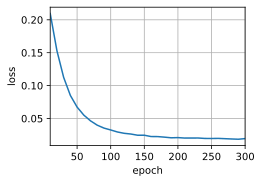

In [89]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10

lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

## 参数值:(64,10)
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

'''
len(src_vocab)=184
参数值(184, 32, 32, 2, 0.1)
返回值：
output的形状:(num_steps,batch_size,num_hiddens): (10, 64, 32)
state的形状:(num_layers,batch_size,num_hiddens)：(2, 64, 32)
'''
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)

'''
len(tgt_vocab)=201
参数值(201, 32, 32, 2, 0.1)
output的形状:(batch_size,num_steps,vocab_size)：(64, 10, 201)
state的形状:(num_layers,batch_size,num_hiddens)：(2, 64, 32)
'''
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
#
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 9.7.5 seq2seq模型预测

- 为了采用一个接着一个词元的方式预测输出序列，
每个解码器当前时间步的输入都将来自于前一时间步的预测词元。
- 与训练类似，序列开始词元（“&lt;bos&gt;”）
在初始时间步被输入到解码器中。
- 该预测过程如 图9.7.3所示，
当输出序列的预测遇到序列结束词元（“&lt;eos&gt;”）时，预测就结束了。

<center><img src='../img/seq2seq-predict.svg'/></center>
<center>图9.7.3 使用循环神经网络编码器-解码器逐词元地预测输出序列</center>

- 将在9.8节中介绍不同的序列生成策略。

In [90]:
#@save
## 预测参数函数：src_vocab：184，tgt_vocab：201，num_steps：10
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval() ##与train函数对应
    '''
    以'go .'为例, src_tokens是['go', ' ', '.', '<eos>'],
    经过如下处理之后变成[9, 0, 4, 3]
    '''
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]    
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    
    ## 将源tokens截断或填充为长度10的序列
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    
    # 添加批量维，enc_x的形状从(10,)变成为(1,10)
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    
    
    '''
    编码层的输入(1,10)的序列,有效长度为：4
    初始化编码层和解码层，注意解码层的的输入使用了编码层输出。

    enc_outputs包含两个：一个是所有时间步的隐状态，一个是最后一个时间步的隐状态。
    dec_state：(2,1,32)
    '''
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    
    ## 添加批量轴，此处是解码器起始预测token，即'<bos>'    
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        # Y:(1,1,201), dec_state:(2,1,32)
        Y, dec_state = net.decoder(dec_X, dec_state)    
        
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        ## 这就是模型进行预测时，要将上一个时间步的输出Y_t-1'作为本时间步的输入
        ## 注意：这种操作只是在预测阶段发生，在训练阶段没有
        dec_X = Y.argmax(dim=2)        
        
        ## item()函数从张量中提取标量,是词表中的索引，通过idx_to_token函数获取词元
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        
        # 保存注意力权重（后面章节将重点讨论）,本例没有attention_weights变量
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [91]:
tgt_vocab['<bos>'], torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)

(2, tensor([[2]], device='cuda:0'))

In [92]:
tgt_vocab['<eos>'],tgt_vocab['<pad>'],tgt_vocab['<unk>']

(3, 1, 0)

In [93]:
arg = torch.arange(1*1*201).reshape(1,1,201)
arg.argmax(dim=2), (arg.argmax(dim=2)).squeeze(dim=0).item(),arg.argmax()

(tensor([[200]]), 200, tensor(200))

----------
- **说明：unsqueeze与squeeze函数用法**

In [94]:
s = torch.tensor([1,2,3,4])
s1=torch.unsqueeze(s,dim=0)
s2=torch.unsqueeze(s,dim=1)
s1,s1.shape,s2,s2.shape

(tensor([[1, 2, 3, 4]]),
 torch.Size([1, 4]),
 tensor([[1],
         [2],
         [3],
         [4]]),
 torch.Size([4, 1]))

In [95]:
s3=torch.squeeze(s1)
s3.shape, s3

(torch.Size([4]), tensor([1, 2, 3, 4]))

In [96]:
src_vocab['go'],src_vocab[' '],src_vocab['.'],src_vocab['<eos>']

(9, 0, 4, 3)

In [97]:
## 源词表和目标词表的'eos'编码是一样的
src_vocab['<eos>'],tgt_vocab['<eos>']

(3, 3)

In [98]:
## go .的预测结果
tgt_vocab.idx_to_token[16],tgt_vocab.idx_to_token[5],tgt_vocab.idx_to_token[3]

('va', '!', '<eos>')

In [99]:
## 使用tensor的item()函数返回一个标量(此处是int类型)，而不是张量
s1.argmax(),s1.argmax().item(),type(s1.argmax().item())

(tensor(3), 3, int)

-----------

## 9.7.6 seq2seq模型预测序列的评估

- 可以通过与真实的标签序列进行比较来评估预测序列。
- 虽然BLEU(Bilingual Evaluation Understudy)，最先是用于评估机器翻译的结果，
但现在它已经被广泛用于**测量许多应用的输出序列的质量**。
- 原则上说，对于预测序列中的任意$n$元语法（n-grams），
BLEU的评估都是**这个$n$元语法是否出现在标签序列中**。
- BLEU定义为：
$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n} \tag{9.7.4}$$
  - 其中$\mathrm{len}_{\text{label}}$表示标签序列中的词元数和
$\mathrm{len}_{\text{pred}}$表示预测序列中的词元数，
$k$是用于匹配的最长的$n$元语法。
  - 另外，用$p_n$表示$n$元语法的精确度，它是两个数量的比值：
    - 第一个是预测序列与标签序列中匹配的$n$元语法的数量，
    - 第二个是预测序列中$n$元语法的数量的比率。
  - 具体地说，给定标签序列$A$、$B$、$C$、$D$、$E$、$F$和预测序列$A$、$B$、$B$、$C$、$D$，
我们有$p_1 = 4/5$、$p_2 = 3/4$、$p_3 = 1/3$和$p_4 = 0$。

- 根据公式9.7.4中BLEU的定义，
当预测序列与标签序列完全相同时，BLEU为$1$。
- 此外，由于$n$元语法越长则匹配难度越大，
所以BLEU为更长的$n$元语法的精确度分配更大的权重。
  - 具体来说，当$p_n$固定时，$p_n^{1/2^n}$
会随着$n$的增长而增加（原始论文使用$p_n^{1/n}$）。
  - 而且，由于预测的序列越短获得的$p_n$值越高，
所以公式9.7.4中乘法项之前的系数用于惩罚较短的预测序列。
  - 例如，当$k=2$时，给定标签序列$A$、$B$、$C$、$D$、$E$、$F$
和预测序列$A$、$B$，尽管$p_1 = p_2 = 1$，
惩罚因子$\exp(1-6/2) \approx 0.14$会降低BLEU。


- **BLEU的代码实现**如下:

In [100]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [103]:
# 简单测试bleu函数
bleu('A B B C D','A B C D E F',k=2)

0.6814773296495302

In [102]:
# 手工计算过程
import numpy as np
np.exp(-0.2)*((4/5)**(1/2))*((3/4)**(1/4))

0.6814773296495301

- 最后，利用训练好的循环神经网络“编码器－解码器”模型，
**将几个英语句子翻译成法语**，并计算BLEU的最终结果。


In [108]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    '''
    eng是一个句子。num_steps=10
    '''
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va ceci !, bleu 0.000
i lost . => j'ai perdu perdu perdu ., bleu 0.651
he's calm . => fais-moi confiance bien perdu ., bleu 0.000
i'm home . => je suis chez partie ., bleu 0.752


## 小结

* 根据“编码器-解码器”架构的设计，
  我们可以使用两个循环神经网络来设计一个序列到序列学习的模型。
* 在实现编码器和解码器时，我们可以使用多层循环神经网络。
* 我们可以使用遮蔽来过滤不相关的计算，例如在计算损失时。
* 在“编码器－解码器”训练中，强制教学方法将原始输出序列（而非预测结果）输入解码器。
* BLEU是一种常用的评估方法，它通过测量预测序列和标签序列之间的$n$元语法的匹配度来评估预测。